In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from model_eval_plotting import evaluate_model
from model_eval_plotting import plot_predictions_vs_targets

from CNN_setup import SimpleCNN
from CNN_setup import TensorDataset

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


# Prep training data

In [2]:
ds_train1 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps.zarr", engine="zarr", chunks={}
) 
ds_train1 = ds_train1.drop_vars(['Q_star', 'Q_out'])
ds_train2 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr2.zarr", engine="zarr", chunks={}
) 
ds_train3 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr3.zarr", engine="zarr", chunks={}
) 
ds_train4 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr4.zarr", engine="zarr", chunks={}
) 
ds_train5 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr5.zarr", engine="zarr", chunks={}
) 
datasets = [ds_train1, ds_train2, ds_train3, ds_train4, ds_train5]

# Concatenate along the 'time' dimension
combined_dataset = xr.concat(datasets, dim='time')
combined_dataset

<xarray.Dataset> Size: 207MB
Dimensions:   (time: 176, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 1kB 0181-01-01 12:00:00 ... 0185-12-26 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    q_ref     (time, yt_ocean, xt_ocean) float64 34MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 34MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 34MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 34MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 34MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    slp       (time, yt_ocean, xt_ocean) float64 34MB dask.array<chunksize=(9, 82, 75), meta=np.ndarray>

In [3]:
# Total number of samples
n_samples = len(combined_dataset.time)  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
train_data = combined_dataset.isel(time=train_indices)
val_data = combined_dataset.isel(time=val_indices)
test_data = combined_dataset.isel(time=test_indices)

print("Training set size:", len(train_data.time))
print("Validation set size:", len(val_data.time))
print("Testing set size:", len(test_data.time))


Training set size: 123
Validation set size: 26
Testing set size: 27


In [4]:
# Create a 4D tensor using all variables from ds_testing
# First, extract the values from the dataset
u_rel = train_data['u_rel'].values
v_rel = train_data['v_rel'].values
uv_sum = u_rel + v_rel

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
training_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, uv_sum], axis=3))

# Now data_array is a 4D tensor
training_NN_inputs


tensor([[[[ 1.2990, -7.3093, -6.0103],
          [ 1.2850, -7.2671, -5.9822],
          [ 1.2723, -7.2236, -5.9513],
          ...,
          [-1.0740, -0.5067, -1.5807],
          [-1.1131, -0.4613, -1.5744],
          [-1.1519, -0.4145, -1.5664]],

         [[ 1.2152, -7.2568, -6.0416],
          [ 1.2005, -7.2144, -6.0139],
          [ 1.1873, -7.1708, -5.9835],
          ...,
          [-1.0426, -0.4899, -1.5325],
          [-1.0801, -0.4449, -1.5251],
          [-1.1174, -0.3986, -1.5160]],

         [[ 1.1306, -7.2045, -6.0739],
          [ 1.1153, -7.1619, -6.0466],
          [ 1.1014, -7.1181, -6.0167],
          ...,
          [-1.0211, -0.4717, -1.4928],
          [-1.0569, -0.4272, -1.4841],
          [-1.0925, -0.3813, -1.4738]],

         ...,

         [[-6.9708,  1.1059, -5.8649],
          [-6.9688,  1.1297, -5.8392],
          [-6.9663,  1.1532, -5.8131],
          ...,
          [-8.3971,  2.5824, -5.8147],
          [-8.4024,  2.6068, -5.7956],
          [-8.4069,  2

In [5]:
# Create a 4D tensor using all variables from ds_testing
# First, extract the values from the dataset
u_rel = val_data['u_rel'].values
v_rel = val_data['v_rel'].values
uv_sum = u_rel + v_rel

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
validation_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, uv_sum], axis=3))

# Now data_array is a 4D tensor
validation_NN_inputs


tensor([[[[ 1.4865,  4.8611,  6.3476],
          [ 1.5063,  4.8564,  6.3627],
          [ 1.5267,  4.8521,  6.3789],
          ...,
          [ 4.5859,  2.5334,  7.1193],
          [ 4.5752,  2.5383,  7.1135],
          [ 4.5642,  2.5430,  7.1073]],

         [[ 1.4969,  4.8472,  6.3441],
          [ 1.5167,  4.8424,  6.3591],
          [ 1.5372,  4.8381,  6.3752],
          ...,
          [ 4.5016,  2.5776,  7.0792],
          [ 4.4900,  2.5828,  7.0728],
          [ 4.4781,  2.5879,  7.0660]],

         [[ 1.5070,  4.8328,  6.3398],
          [ 1.5268,  4.8279,  6.3547],
          [ 1.5472,  4.8235,  6.3707],
          ...,
          [ 4.4164,  2.6228,  7.0393],
          [ 4.4039,  2.6284,  7.0322],
          [ 4.3911,  2.6337,  7.0248]],

         ...,

         [[-7.5540,  5.1786, -2.3754],
          [-7.5342,  5.1605, -2.3737],
          [-7.5143,  5.1424, -2.3719],
          ...,
          [-3.9563,  5.2917,  1.3354],
          [-3.9417,  5.3065,  1.3649],
          [-3.9275,  5

In [6]:
# Create a 4D tensor using all variables from ds_testing
# First, extract the values from the dataset
u_rel = test_data['u_rel'].values
v_rel = test_data['v_rel'].values
uv_sum = u_rel + v_rel

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
testing_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, uv_sum], axis=3))

# Now data_array is a 4D tensor
testing_NN_inputs


tensor([[[[ 8.8136, -1.7048,  7.1088],
          [ 8.8336, -1.7055,  7.1281],
          [ 8.8531, -1.7061,  7.1470],
          ...,
          [ 8.5091, -2.7363,  5.7728],
          [ 8.4980, -2.7429,  5.7552],
          [ 8.4875, -2.7484,  5.7390]],

         [[ 8.7410, -1.6798,  7.0612],
          [ 8.7609, -1.6800,  7.0809],
          [ 8.7802, -1.6801,  7.1001],
          ...,
          [ 8.3884, -2.6744,  5.7140],
          [ 8.3766, -2.6809,  5.6957],
          [ 8.3654, -2.6864,  5.6790]],

         [[ 8.6644, -1.6509,  7.0135],
          [ 8.6840, -1.6505,  7.0335],
          [ 8.7031, -1.6501,  7.0530],
          ...,
          [ 8.2660, -2.6129,  5.6531],
          [ 8.2535, -2.6194,  5.6341],
          [ 8.2415, -2.6249,  5.6167]],

         ...,

         [[-9.1662,  3.6632, -5.5030],
          [-9.1676,  3.6676, -5.4999],
          [-9.1688,  3.6720, -5.4968],
          ...,
          [-8.7170,  4.9147, -3.8024],
          [-8.6996,  4.9295, -3.7701],
          [-8.6819,  4

# Set up NN architecture

In [7]:
# Set the values you want
in_channels = 2  # num of input channels
image_height = training_NN_inputs.shape[1]
image_width = training_NN_inputs.shape[2]
output_channels = 1 #output can be in grayscale, num of output channels

# Instantiate the model with the parameters
model = SimpleCNN(in_channels, image_height, image_width, output_channels)

# Check the model architecture
print(model)

SimpleCNN(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=23040, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=24450, bias=True)
)


In [8]:
criterion = nn.MSELoss()  # Use appropriate loss for your task
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training NN

In [9]:
# Define the number of input channels (e.g., first 2 channels as input)
input_channels = 2
train_dataset = TensorDataset(training_NN_inputs)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

In [10]:
val_dataset = TensorDataset(validation_NN_inputs)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

In [11]:
num_epochs = 50  # Number of epochs to train

In [12]:
loss_values = []  # Training loss for each epoch
val_loss_values = []  # Validation loss for each epoch

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, targets in train_loader:
        # Determine if batch size is 1 or larger
        if inputs.shape[0] == 1:
            # Batch size 1 handling (inputs shape: [1, y, x, variables (6)])
            inputs = inputs.squeeze(0).permute(2, 0, 1).float()  # Reshape to (vars, y, x) --> CNN input expects vars/channels first
            targets = targets.squeeze(0).float()  # Shape: (y, x)
            outputs = model(inputs.unsqueeze(0))  # Add batch dimension back for CNN (shape: [1, vars, y, x])
            targets = targets.unsqueeze(0)  # Add batch dimension to targets
        else:
            # Larger batch size handling (inputs shape: [batch_size, y, x, variables (6)])
            inputs = inputs.permute(0, 3, 1, 2).float()  # Reshape to (batch_size, vars, y, x) --> CNN input expects vars/channels first
            targets = targets.float()  # Shape: (batch_size, y, x)
            outputs = model(inputs)  # No need to add batch dimension back for CNN

        # Compute loss
        loss = criterion(outputs, targets)

        # Zero/reset the parameter gradients before next iteration
        optimizer.zero_grad()

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = running_loss / len(train_loader)
    loss_values.append(average_loss)

    # Validation phase: Use evaluate_model
    val_loss, _, _ = evaluate_model(model, val_loader, criterion)
    val_loss_values.append(val_loss)

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Training Loss: {average_loss:.4f}, Validation Loss: {val_loss:.4f}")

print("Training complete!")


Epoch [1/50], Training Loss: 10.0791, Validation Loss: 2.8008
Epoch [2/50], Training Loss: 5.0750, Validation Loss: 1.5256
Epoch [3/50], Training Loss: 1.7078, Validation Loss: 0.8022
Epoch [4/50], Training Loss: 1.2303, Validation Loss: 0.8108
Epoch [5/50], Training Loss: 0.9849, Validation Loss: 0.8259
Epoch [6/50], Training Loss: 1.2367, Validation Loss: 0.8316
Epoch [7/50], Training Loss: 1.0942, Validation Loss: 0.8948
Epoch [8/50], Training Loss: 0.9136, Validation Loss: 0.6449
Epoch [9/50], Training Loss: 0.7186, Validation Loss: 0.6822
Epoch [10/50], Training Loss: 0.9254, Validation Loss: 0.7227
Epoch [11/50], Training Loss: 0.8212, Validation Loss: 0.6791
Epoch [12/50], Training Loss: 0.6706, Validation Loss: 0.5311
Epoch [13/50], Training Loss: 1.2494, Validation Loss: 0.6133
Epoch [14/50], Training Loss: 0.7119, Validation Loss: 0.6925
Epoch [15/50], Training Loss: 0.8776, Validation Loss: 0.6589
Epoch [16/50], Training Loss: 0.5381, Validation Loss: 0.5091
Epoch [17/50], T

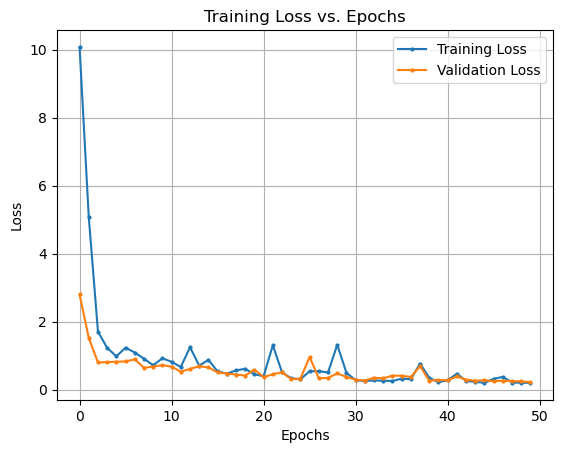

In [13]:
epochs_plot = list(range(0,num_epochs))

# Plot training losses against epochs
plt.plot(epochs_plot, loss_values, marker='o', markersize=2, label='Training Loss')
plt.plot(epochs_plot, val_loss_values, marker='o', markersize=2, label='Validation Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# Testing dataset

In [14]:
# Assuming you have a test dataset similar to your training dataset
test_dataset = TensorDataset(testing_NN_inputs)  # Replace with your actual test tensor data
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Set shuffle=False for testing

In [15]:
# Define your criterion (loss function)
criterion = nn.MSELoss()  # or whatever loss function you're using

# Evaluate the model on the test dataset
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion)

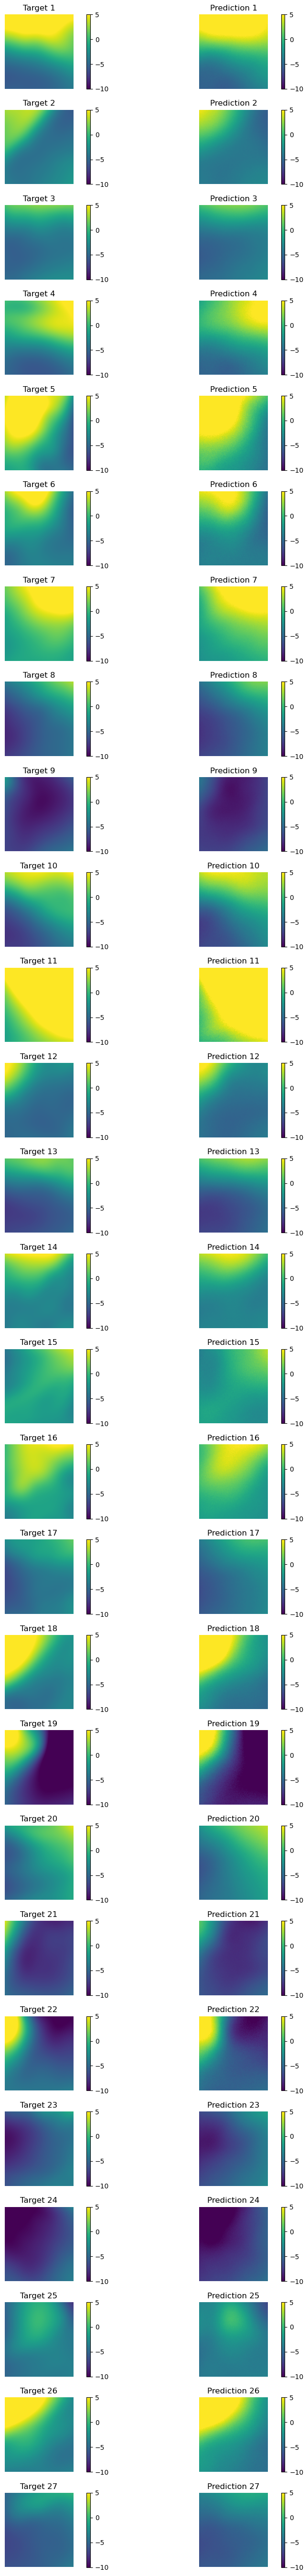

In [16]:
# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=len(test_data.time))  # Change num_samples as needed


In [17]:
def calculate_rmse(predictions, targets):

    # Compute the squared differences
    squared_diff = (predictions - targets) ** 2
    
    # Calculate the mean of squared differences
    mean_squared_diff = squared_diff.mean(dim=(1, 2))  # Mean across height and width (assuming shape [batch, height, width])
    
    # Calculate RMSE by taking the square root
    rmse = torch.sqrt(mean_squared_diff)  # Shape will be (batch_size,)
    
    return rmse

# Assuming predictions and targets are your outputs from the evaluation function
rmse_values = calculate_rmse(predictions, targets)

# List to store individual RMSE values
individual_rmse_values = []

# Print RMSE for each prediction-target pair
for i in range(0, predictions.shape[0]):
    rmse_value = calculate_rmse(predictions[i], targets[i])
    individual_rmse_values.append(rmse_value.item())  # Store the RMSE for plotting
    print(f"RMSE for prediction-target pair {i + 1}: {rmse_value.item():.4f}")


RMSE for prediction-target pair 1: 0.6123
RMSE for prediction-target pair 2: 0.7064
RMSE for prediction-target pair 3: 0.2518
RMSE for prediction-target pair 4: 0.6961
RMSE for prediction-target pair 5: 0.9825
RMSE for prediction-target pair 6: 0.5335
RMSE for prediction-target pair 7: 0.4956
RMSE for prediction-target pair 8: 0.2896
RMSE for prediction-target pair 9: 0.4054
RMSE for prediction-target pair 10: 0.5842
RMSE for prediction-target pair 11: 0.8675
RMSE for prediction-target pair 12: 0.3103
RMSE for prediction-target pair 13: 0.3042
RMSE for prediction-target pair 14: 0.3058
RMSE for prediction-target pair 15: 0.4868
RMSE for prediction-target pair 16: 0.5485
RMSE for prediction-target pair 17: 0.4123
RMSE for prediction-target pair 18: 0.9097
RMSE for prediction-target pair 19: 1.2470
RMSE for prediction-target pair 20: 0.3839
RMSE for prediction-target pair 21: 0.5842
RMSE for prediction-target pair 22: 0.6405
RMSE for prediction-target pair 23: 0.2915
RMSE for prediction-

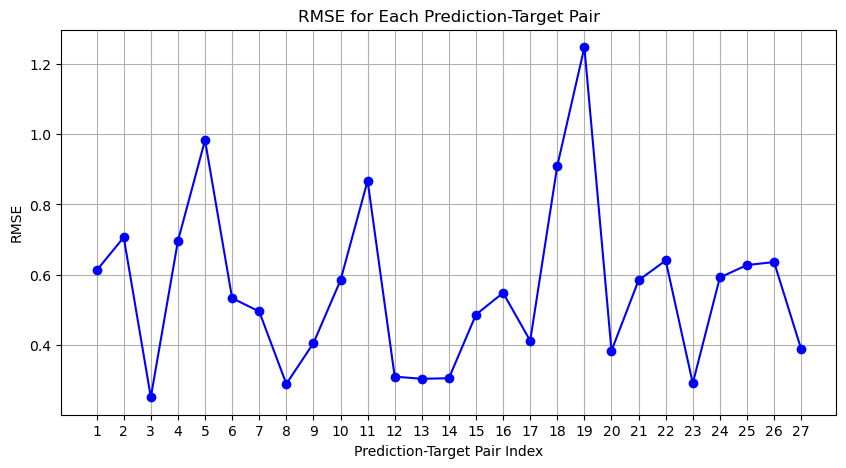

In [18]:
# Plot RMSE values
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(individual_rmse_values) + 1), individual_rmse_values, marker='o', linestyle='-', color='b')
plt.title('RMSE for Each Prediction-Target Pair')
plt.xlabel('Prediction-Target Pair Index')
plt.ylabel('RMSE')
plt.xticks(range(1, len(individual_rmse_values) + 1))  # Set x-ticks to match the number of pairs
plt.grid(True)
plt.show()